In [2]:
import pandas as pd
import plotly.express as px
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.style.use('./mesa.mplstyle10')

In [3]:
def Fryer_delayed(Mco, Mfinal):
    # --------------- calculate mass of the proto NS Mproto --------------
    if Mco < 3.5:
        Mproto = 1.2
    elif Mco >= 3.5 and Mco < 6: 
        Mproto = 1.3
    elif Mco >= 6. and Mco < 11.:
        Mproto = 1.4
    else:
        Mproto = 1.6
        
    a2 = 0.133 - (0.093/(Mfinal - Mproto))
    b2 = -11*a2 + 1
    # --------------- calculate the amount of fallback onto the compact remnant ----------------    
    if Mco < 2.5:
        Mfb = 0.2
    elif Mco >= 2.5 and Mco <3.5:
        Mfb = 0.5*Mco - 1.05
    elif Mco >= 3.5 and Mco < 11:
        fb = a2*Mco + b2
        Mfb = fb*(Mfinal - Mproto)
    else:
        fb = 1.
        Mfb = fb*(Mfinal - Mproto)

    # -------------- calculate the final baryonic mass of the compact remnant --------------------
    Mrem_b = Mproto + Mfb
    
    return 0.9*Mrem_b   #returns the gravitational mass of the BH

In [4]:
# file = 'data_paper_4/NonRel_NT/'
# symlink = [150, 300, 450, 600, 750, 911]#, 1100, 1250, 1439]
# cols = ['Mexp', 'AMexp', 'Mbh', 'abh', 'Rexp']
# out_data = []

# df_0 = pd.read_csv(file + f'Run_data_{symlink[0]}.txt', delim_whitespace = True)
# for Z in range(len(symlink) - 1):
#     df_1 = pd.read_csv(file + f'Run_data_{symlink[Z+1]}.txt',  delim_whitespace = True)
# #     out_data.append(df['Mexp'].values, )
#     df_0 = pd.concat([df_0, df_1], axis=0, ignore_index=True)
    

# df_0.to_csv('data_paper_4/NonRel_NT/concatenated_file_nonrel_NT.csv', index=False)

In [5]:
dataMAD = pd.read_csv("./Output_data/concatenated_file_MAD.csv")
dataNT = pd.read_csv("./Output_data/concatenated_file_rel.csv")
datanonrel_MAD = pd.read_csv("./Output_data/concatenated_file_nonrel_MAD.csv")
datanonrel_NT = pd.read_csv("./Output_data/concatenated_file_nonrel_NT.csv")
dataMAD.head()

,Mbh,abh,AMexp,Mexp,filename,tff,Md,Mco,Rexp,MHe_form,...,MHe_dep,AMfinal_He_dep,R_He_dep,Omega_mean_He_dep,Omega_mean_exp,Mc12_dep,AM_c12_dep,R_c12_dep,Omega_c12_dep,Eacc
0,4.983,0.15150,3.256000e+49,4.984222,0/LOGS/profile72,1314.658139,5.151000e-09,2.970036,1.400817,4.999526,...,4.989663,3.300000e+49,1.453448,0.000259,0.000877,4.984223,3.256000e+49,1.453448,0.000259,4.094000e+47
1,6.964,0.12890,5.400000e+49,6.964187,1/LOGS/profile12,2998.196017,1.595000e-12,4.696979,2.713960,6.998907,...,6.975745,5.501000e+49,2.713960,0.000227,0.003195,6.964187,5.400000e+49,2.713960,0.000227,5.883000e+45
2,8.938,0.11200,7.782000e+49,8.938068,2/LOGS/profile35,750.145635,0.000000e+00,6.534862,1.206268,8.998252,...,8.955658,7.956000e+49,1.206268,0.000181,0.000785,8.938069,7.782000e+49,1.206268,0.000181,0.000000e+00
3,10.900,0.10100,1.038000e+50,10.904303,3/LOGS/profile11,444.193695,0.000000e+00,8.212380,0.882759,10.996840,...,10.917031,1.053000e+50,0.895032,0.000144,0.006528,10.904303,1.038000e+50,0.895032,0.000144,0.000000e+00
4,12.860,0.09061,1.300000e+50,12.862849,4/LOGS/profile15,384.282303,0.000000e+00,9.931898,0.847345,12.996818,...,12.898853,1.344000e+50,0.997860,0.000124,0.000364,12.866603,1.306000e+50,0.916727,0.000124,0.000000e+00


### Calculating Fryer remnant masses

In [6]:
### Calculating remnant masss from Fryer method
MBH_Fryer = []
for i in range(len(dataNT)):
    MBH = Fryer_delayed(dataNT.loc[i,'Mco'], dataNT.loc[i,'Mexp'])
    MBH_Fryer.append(MBH)

### Plotting

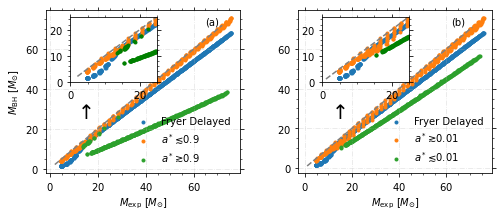

In [8]:
from matplotlib.gridspec import GridSpec
plt.figure(figsize = (8.,3))
gs = GridSpec(1, 2, wspace = 0.3)

plt.subplot(gs[0])
plt.scatter(dataNT['Mexp'], MBH_Fryer)#, z='Mbh')

mask = dataNT["abh"] <=.9
mask1 = dataNT[mask]['Mbh'] / dataNT[mask]['Mexp'] < 1
plt.scatter(dataNT[mask][mask1]['Mexp'], dataNT[mask][mask1]['Mbh'])#, z='Mbh')

mask = dataNT["abh"] > .9
plt.scatter(dataNT[mask]['Mexp'], dataNT[mask]['Mbh'])#, z='Mbh')

plt.legend(['Fryer Delayed', '$a^* \\lesssim 0.9$', '$a^* \\gtrsim 0.9$'], fontsize = 10, loc = 'lower right')# bbox_to_anchor=(0.1, 0.3, 0.5, 0.6))
# 
x = np.arange(2,80, 10)
y = x
plt.text(65, 72, '(a)')
# plt.title('NT accretion flow', pad = 10)
plt.grid(linestyle = '-.', alpha = .3)
plt.plot(x, y, linestyle = '--', color = 'gray')
plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}]$')
plt.ylabel('$M_{\\rm BH} \,\, [M_{\\odot}]$')
plt.text(10, 25, '$\\uparrow$', fontsize = 20)

MBH_Fryer = []
for i in range(len(dataNT)):
    MBH = Fryer_delayed(dataNT.loc[i,'Mco'], dataNT.loc[i,'Mexp'])
    MBH_Fryer.append(MBH)
   
ax2 = plt.axes([.1675, .55, .15, .3]) #left, bottom, width, height (range 0 to 1)
ax2.scatter(dataNT['Mexp'], MBH_Fryer, alpha = 0.8)#, z='Mbh')


# -------------------------------  Inset --------------------------
mask = dataNT["abh"] <=.9
mask1 = dataNT[mask]['Mbh'] / dataNT[mask]['Mexp'] < 1
ax2.scatter(dataNT[mask][mask1]['Mexp'], dataNT[mask][mask1]['Mbh'])#, z='Mbh')

mask = dataNT["Mexp"] <= 25
mask1 = dataNT[mask]['abh'] > .9
ax2.scatter(dataNT[mask][mask1]['Mexp'], dataNT[mask][mask1]['Mbh'], color = 'green')#, z='Mbh')
ax2.plot(x[0:4], y[0:4], linestyle = '--', color = 'gray')
ax2.set_xlim(0,25)
ax2.set_ylim(0,25)
# ax2.plot(x[3:8],y[3:8])


# -------------------------------------

plt.subplot(gs[1])
plt.scatter(dataMAD['Mexp'], MBH_Fryer)#, z='Mbh')

mask = dataMAD["abh"] >= 0.01
mask1 = dataMAD[mask]['Mbh'] / dataMAD[mask]['Mexp'] < 1
plt.scatter(dataMAD[mask][mask1]['Mexp'], dataMAD[mask][mask1]['Mbh'])#, z='Mbh')

mask = dataMAD["abh"] < .01
plt.scatter(dataMAD[mask]['Mexp'], dataMAD[mask]['Mbh'])#, z='Mbh')

plt.legend(['Fryer Delayed', '$a^* \gtrsim 0.01$', '$a^* \\lesssim 0.01$'],fontsize = 10, loc = 'lower right')#bbox_to_anchor=(0.1, 0.3, 0.5, 0.6))
# 
x = np.arange(1,80, 10)
y = x
plt.text(62, 72, '(b)')
# plt.title('MA accretion flow', pad = 10)
plt.plot(x, y, linestyle = '--', color = 'gray')
plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}]$')
plt.grid(linestyle = '-.', alpha = .3)
plt.text(10, 25, '$\\uparrow$', fontsize = 20)

ax3 = ax3 = plt.axes([.605, .55, .15, .3]) #left, bottom, width, height (range 0 to 1)
ax3.scatter(dataMAD['Mexp'], MBH_Fryer, alpha = 0.8)#, z='Mbh')

mask = dataMAD["abh"] >= 0.01
mask1 = dataMAD[mask]['Mbh'] / dataMAD[mask]['Mexp'] < 1
ax3.scatter(dataMAD[mask][mask1]['Mexp'], dataMAD[mask][mask1]['Mbh'])#, z='Mbh')

mask = dataMAD["Mexp"] <= 25
mask1 = dataMAD[mask]['abh'] < .01
ax3.scatter(dataMAD[mask][mask1]['Mexp'], dataMAD[mask][mask1]['Mbh'], color = 'green')#, z='Mbh')
ax3.plot(x[0:4], y[0:4], linestyle = '--', color = 'gray')
ax3.set_xlim(0,25)
ax3.set_ylim(0,25)


# plt.ylabel('$M_{\\rm BH} \,\, [M_{\\odot}]$')
plt.savefig('./Mexp_MBH.png')

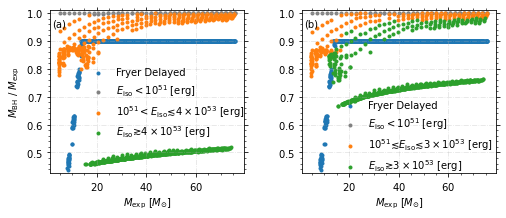

In [9]:
plt.figure(figsize = (8,3))
gs = GridSpec(1, 2, wspace = 0.3)

plt.subplot(gs[0])
coef = 0.01/0.05
### fractional change
MBH_Fryer = []
for i in range(len(dataNT)):
    MBH = Fryer_delayed(dataNT.loc[i,'Mco'], dataNT.loc[i,'Mexp'])
    MBH_Fryer.append(MBH)
    
plt.scatter(dataNT['Mexp'], MBH_Fryer/ dataNT['Mexp'])#, z='Mbh')

mask = coef*dataNT['Eacc'] <=1e51
plt.scatter(dataNT[mask]['Mexp'], dataNT[mask]['Mbh'] / dataNT[mask]['Mexp'], color = 'grey')#, z='Mbh')

# mask = dataNT["abh"] >= .075
mask = (coef*dataNT['Eacc'] > 1e51) & (coef*dataNT['Eacc'] < 4e53)
plt.scatter(dataNT[mask]['Mexp'], dataNT[mask]['Mbh'] / dataNT[mask]['Mexp'])#, z='Mbh')

# mask = dataNT["abh"] >=.9
mask = coef*dataNT['Eacc']  >= 4e53
plt.scatter(dataNT[mask]['Mexp'], dataNT[mask]['Mbh'] / dataNT[mask]['Mexp'])#, z='Mbh')
 
 
plt.legend(['Fryer Delayed', '$E_{\\rm iso} <  10^{51}$ [erg]', '$10^{51} < E_{\\rm iso} \\lesssim 4 \\times 10^{53}$ [erg]', \
            '$E_{\\rm iso} \\gtrsim 4 \\times 10^{53}$ [erg]'], fontsize = 10, bbox_to_anchor=(0.15, 0.15, 0.5, 0.5))

# plt.title('NT accretion flow', pad = 10)
plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}]$')
plt.ylabel('$M_{\\rm BH}$ / $M_{\\rm exp}$')
plt.ylim(0.425,1.01)
plt.grid(linestyle = '-.', alpha =.35)
plt.text(2, 0.95, '(a)')


# -------------------------------------

plt.subplot(gs[1])
coef = 1/0.05
### fractional change
MBH_Fryer = []
for i in range(len(dataMAD)):
    MBH = Fryer_delayed(dataMAD.loc[i,'Mco'], dataMAD.loc[i,'Mexp'])
    MBH_Fryer.append(MBH)
    
plt.scatter(dataMAD['Mexp'], MBH_Fryer/ dataMAD['Mexp'])#, z='Mbh')

mask = coef*dataMAD['Eacc'] <=1e51
plt.scatter(dataMAD[mask]['Mexp'], dataMAD[mask]['Mbh'] / dataMAD[mask]['Mexp'], color = 'grey')#, z='Mbh')

# mask = dataMAD["abh"] >= .075
mask = (coef*dataMAD['Eacc'] > 1e51) & (coef*dataMAD['Eacc'] <= 3e53)
plt.scatter(dataMAD[mask]['Mexp'], dataMAD[mask]['Mbh'] / dataMAD[mask]['Mexp'])#, z='Mbh')

# mask = dataMAD["abh"] <=.02
mask = coef*dataMAD['Eacc']  > 3e53
plt.scatter(dataMAD[mask]['Mexp'], dataMAD[mask]['Mbh'] / dataMAD[mask]['Mexp'])#, z='Mbh')
 
plt.legend(['Fryer Delayed', '$E_{\\rm iso} <  10^{51}$ [erg]', '$10^{51} \\lesssim E_{\\rm iso} \\lesssim 3 \\times 10^{53}$ [erg]', \
            '$E_{\\rm iso} \\gtrsim 3 \\times 10^{53}$ [erg]'], fontsize = 10, \
           bbox_to_anchor=(0.15, 0.15, 0.35, 0.35))
# plt.title('MA accretion flow', pad = 10)
plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}]$')
# plt.ylabel('$M_{\\rm BH}$ / $M_{\\rm exp}$')
# plt.xlim(1,68)
plt.ylim(0.425,1.01)
plt.text(2, 0.95, '(b)')
plt.grid(linestyle = '-.', alpha =.35)

plt.savefig('./Mexp_MBH_ratio.png')

In [11]:
def transform_spin(x, y):
    df = pd.DataFrame()
    
    df["x"] = x
    df["y"] = y
    
    df["sqrt(xy)"] = np.sqrt(df['x'] * df['y'])
    df["sqrt(x)"] = np.sqrt(df['x'])
    df["sqrt(y)"] = np.sqrt(df['y'])

    df["sqrt(x)x"] = np.sqrt(df['x']) * df['x']
    df["sqrt(y)x"] = np.sqrt(df['y'])  * df['x']

    df["sqrt(x)y"] = np.sqrt(df['x'])  * df['y']
    df["sqrt(y)y"] = np.sqrt(df['y'])  * df['y']
    df["square(x)"] = df['x'] * df['x']
    df["square(y)"] = df['y'] * df['y']

    df["xy"] = df['x'] * df['y']
    df["xxy"] = df['x'] * df['x'] * df['y']
    df["xyy"] = df['x'] * df['y'] * df['y']
    
    features = ["sqrt(xy)", "sqrt(x)", "sqrt(y)", "xy", "x", "y"]

    return df[features]

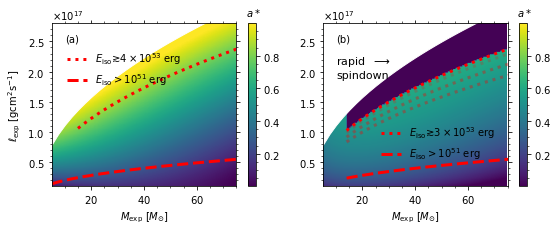

In [12]:
plt.figure(figsize = (9,3))
gs = GridSpec(1, 2, wspace = 0.175)
x = "Mexp"
y = "AMexp"
z = "abh"
msun = 1.989e33
features = ["sqrt(xy)", "sqrt(x)", "sqrt(y)", "xy", "x", "y"]
result = []

plt.subplot(gs[0])
mask = dataNT['abh'] < 1
df_temp = dataNT[mask].copy()
df_temp[y] = (dataNT['AMexp'] / dataNT['Mexp'] / msun / 1e14).astype(float)

df_temp["sqrt(xy)"] = np.sqrt(df_temp[x] * df_temp[y])
df_temp["sqrt(x)"] = np.sqrt(df_temp[x])
df_temp["sqrt(y)"] = np.sqrt(df_temp[y])

df_temp["xy"] = df_temp[x] * df_temp[y]
df_temp["x"] = df_temp[x]
df_temp["y"] = df_temp[y]

min_ = np.min(df_temp[y])
max_ = np.max(dataNT[y]/ dataNT['Mexp'] / msun / 1e14)
x_ = np.arange(5,75,.5)
y_ = np.linspace((min_), (max_), len(x_))
X,Y = np.meshgrid(x_,y_)

model_linear = Ridge()
model_linear.fit(df_temp[features], df_temp[z])
Z1 = np.zeros(X.shape)
for i in range(len(Z1)):
    Z1[i] = model_linear.predict(transform_spin(X[:, i],Y[:, i]))
    Z1[i][Z1[i] < 0] = 1e-3
    Z1[i][Z1[i] > 0.999] = 0.999
    y_temp = (1.25e33*X[:, i])**(1/2)  / 1e14
    Z1[i][(Y[:, i] > y_temp) & (X[:,i] >= 15.)] = 0.999
    
result.append(list(zip(features,model_linear.coef_)))
    
min_ = np.min(df_temp[y]) * 1e14
max_ = np.max(dataNT[y]/ dataNT['Mexp'] / msun / 1e14) * 1e14
# x_ = np.arange(5,75,.005)
# y = np.logspace(np.log10(min_), np.log10(max_), len(x))
vmin = np.min(Z1)
vmax = np.max(Z1)
y_ = np.linspace(min_, max_, len(x_))
plt.imshow(Z1.T, extent=[x_.min(), x_.max(), y_.min(), y_.max()], \
           cmap='viridis', origin='lower', aspect='auto')#, interpolation="gaussian")
cb = plt.colorbar()
cb.ax.set_title('$\,\, a*$', pad = 7)
  
x_ = np.arange(15,80,2.5)
y_ = (7.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':')

x_ = np.arange(5,80,2.5)
y_ = (4e31*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = '--')

y_ = (1.25e33*x_)**(1/2)
plt.fill_between(x_, y_, np.max(y_), color='white')#, alpha=0.3)

plt.text(10, 2.5e17, '(a)')
plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}$]')
plt.ylabel('$\\ell_{\\rm exp}  \,\, [{\\rm gcm}^2 {\\rm s}^{-1}]$')
plt.legend(['$E_{\\rm iso} \\gtrsim 4 \\times 10^{53}$ erg', '$E_{\\rm iso} >  10^{51}$ erg'], \
                                      bbox_to_anchor=[0.75, 0.72], loc = 'center right', fontsize=10)
# plt.yscale('log')
# plt.title('NT accretion flow')
plt.xlim(5,75)
plt.ylim(0.1e17,2.8*1e17)
# plt.xscale('log')

# ---------------------------------  MAD ----------------------------

plt.subplot(gs[1])
mask = dataMAD['abh'] > 0.01
df_temp = dataMAD[mask].copy()
df_temp[y] = (df_temp['AMexp'] / df_temp['Mexp'] / msun / 1e14).astype(float)

df_temp["sqrt(xy)"] = np.sqrt(df_temp[x] * df_temp[y])
df_temp["sqrt(x)"] = np.sqrt(df_temp[x])
df_temp["sqrt(y)"] = np.sqrt(df_temp[y])

df_temp["xy"] = df_temp[x] * df_temp[y]
df_temp["x"] = df_temp[x]
df_temp["y"] = df_temp[y]

min_ = np.min(df_temp[y])
max_ = np.max(dataMAD[y]/ dataMAD['Mexp'] / msun / 1e14)
x_ = np.arange(5,75,.5)
y_ = np.linspace((min_), (max_), len(x_))
X,Y = np.meshgrid(x_,y_)

model_linear = Ridge()
model_linear.fit(df_temp[features], df_temp[z])

Z1 = np.zeros(X.shape)
for i in range(len(Z1)):
    Z1[i] = model_linear.predict(transform_spin(X[:, i],Y[:, i]))
    Z1[i][Z1[i] < 0] = 1e-5
    Z1[i][Z1[i] > 0.6499] = 0.6499
    y_temp = (7.5e32*X[:, i])**(1/2)  / 1e14
    Z1[i][(Y[:, i] > y_temp) & (X[:,i] >= 14.)] = 0.005

result.append(list(zip(features,model_linear.coef_)))
    
min_ = np.min(df_temp[y]) * 1e14
max_ = np.max(dataMAD[y]/ dataMAD['Mexp'] / msun / 1e14) * 1e14
# x_ = np.arange(5,75,.005)
# y = np.logspace(np.log10(min_), np.log10(max_), len(x))
y_ = np.linspace(min_, max_, len(x_))
plt.imshow(Z1.T, extent=[x_.min(), x_.max(), y_.min(), y_.max()], \
           cmap='viridis', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)#, interpolation="gaussian")
cb = plt.colorbar()
cb.ax.set_title('$\,\, a*$', pad = 7)
  
x_ = np.arange(14,80,2.5)
y_ = (7.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':')


y_ = (4e31*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = '--')

x_ = np.arange(14,80,2.5)
y_ = (5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':', alpha = 0.2)
# y_ = (5.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':', alpha = 0.2)
y_ = (6e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':', alpha = 0.2)
# y_ = (6.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':', alpha = 0.2)
y_ = (7e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':', alpha = 0.2)


x_ = np.arange(5,80,2.5)
y_ = (1.25e33*x_)**(1/2)
plt.fill_between(x_, y_, np.max(y_), color='white')#, alpha=0.3)

plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}$]')
# plt.ylabel('$\\ell_{\\rm exp}  \,\, [{\\rm gcm}^2 {\\rm s}^{-1}]$')
plt.legend(['$E_{\\rm iso} \\gtrsim 3 \\times 10^{53}$ erg', '$E_{\\rm iso} >  10^{51}$ erg'], \
                                    bbox_to_anchor=[.985, 0.1], loc = 'lower right', fontsize=10)
# plt.yscale('log')
# plt.text(50, 1.75e17, '$\\downarrow$', fontsize = 20)
plt.xlim(5,75)
plt.ylim(0.1e17,2.8*1e17)
plt.text(10, 2.5e17, '(b)')
plt.text(10, 1.9e17, 'rapid  $\\longrightarrow$ \nspindown', fontsize = 11)
# plt.xscale('log')
plt.savefig('./2D_hist_spin.png')

### 2D histograms for MBH

In [13]:
def transform_MBH(x, y):
    df = pd.DataFrame()
    
    df["x"] = x
    df["y"] = y
    
    df["sqrt(xy)"] = np.sqrt(df['x'] * df['y'])
    df["sqrt(x)"] = np.sqrt(df['x'])
    df["sqrt(y)"] = np.sqrt(df['y'])

    df["sqrt(x)x"] = np.sqrt(df['x']) * df['x']
    df["sqrt(y)x"] = np.sqrt(df['y'])  * df['x']
    df["xy"] = df['x'] * df['y']
    
    features = ["sqrt(xy)", "sqrt(x)", "sqrt(y)", "x", "y"]

    return df[features]

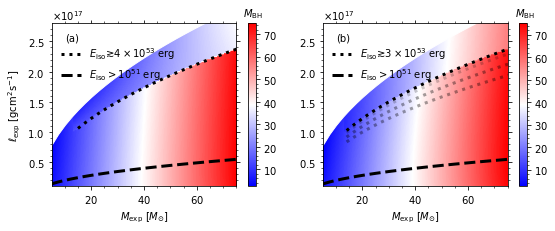

In [14]:
plt.figure(figsize = (9,3))
gs = GridSpec(1, 2, wspace = 0.175)

x = "Mexp"
y = "AMexp"
z = "Mbh"   
msun = 1.989e33
features = ["sqrt(xy)", "sqrt(x)", "sqrt(y)", "x", "y"]
result = []

plt.subplot(gs[0])
mask = dataNT['abh'] <= 0.9 
df_temp = dataNT[mask].copy()
df_temp[y] = (df_temp['AMexp'] / df_temp['Mexp'] / msun / 1e14).astype(float)

df_temp["sqrt(xy)"] = np.sqrt(df_temp[x] * df_temp[y])
df_temp["sqrt(x)"] = np.sqrt(df_temp[x])
df_temp["sqrt(y)"] = np.sqrt(df_temp[y])
df_temp["x"] = df_temp[x]
df_temp["y"] = df_temp[y]

model_linear = Ridge()
model_linear.fit(df_temp[features], df_temp[z])
min_ = np.min(dataNT[y]/ dataNT['Mexp'] / msun / 1e14)
max_ = np.max(dataNT[y]/ dataNT['Mexp'] / msun / 1e14)
x_ = np.arange(5,75,.5)
y_ = np.linspace((min_), (max_), len(x_))
X,Y = np.meshgrid(x_,y_)

Z2 = np.zeros(X.shape)
for i in range(len(Z2)):
    Z2[i] = model_linear.predict(transform_MBH(X[:, i],Y[:, i]))
result.append(list(zip(features,model_linear.coef_)))


# -------------------------------------
mask = dataNT['abh'] > 0.9  
df_temp = dataNT[mask].copy()
df_temp[y] = (df_temp['AMexp'] / df_temp['Mexp'] / msun / 1e14).astype(float)

df_temp["sqrt(xy)"] = np.sqrt(df_temp[x] * df_temp[y])
df_temp["sqrt(x)"] = np.sqrt(df_temp[x])
df_temp["sqrt(y)"] = np.sqrt(df_temp[y])
df_temp["x"] = df_temp[x]
df_temp["y"] = df_temp[y]

model_linear = Ridge()
model_linear.fit(df_temp[features], df_temp[z])

Z3 = np.zeros(X.shape)
for i in range(len(Z3)):
    Z3[i] = model_linear.predict(transform_MBH(X[:, i],Y[:, i]))
result.append(list(zip(features,model_linear.coef_)))

for i in range(len(Z2)):
    y_temp1 = (7.5e32*X[:, i])**(1/2)  / 1e14
    y_temp2 = (1.25e33*X[:, i])**(1/2)  / 1e14
    Z2[i][Z2[i] < 2.5] = 2.5
    if X[0,i] > 12.5:
        Z2[i][(Y[:, i] > y_temp1) & (Y[:, i] < y_temp2)] = Z3[i][(Y[:, i] > y_temp1) & (Y[:, i] < y_temp2)]
#     Z2[i][Y[:, i] > y_temp2] = (np.min(Z2) + np.max(Z2))/2  # this gives 39.2 which is the white color bit

df_temp = dataNT.copy()
df_temp[y] = (dataNT['AMexp'] / dataNT['Mexp'] / msun / 1e14).astype(float)

min_ = np.min(df_temp[y]) * 1e14
max_ = np.max(df_temp[y]) * 1e14
x_ = np.arange(5,75,.005)
# y = np.logspace(np.log10(min_), np.log10(max_), len(x))
y_ = np.linspace(min_, max_, len(x))
plt.imshow(Z2.T, extent=[x_.min(), x_.max(), y_.min(), y_.max()], \
           cmap='bwr', origin='lower', aspect='auto')#, interpolation="gaussian")
cb = plt.colorbar()
cb.ax.set_title('$\,\, M_{\\rm BH}$', pad = 7)
  
x_ = np.arange(15,85,2.5)
y_ = (7.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'k', linestyle = ':')

x_ = np.arange(5,85,2.5)
y_ = (4e31*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'k', linestyle = '--')

x_ = np.arange(5,85,2.5)
y_ = (1.25e33*x_)**(1/2)
plt.fill_between(x_, y_, np.max(y_), color='white')#, alpha=0.3)

    
plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}$]')
plt.ylabel('$\\ell_{\\rm exp}  \,\, [{\\rm gcm}^2 {\\rm s}^{-1}]$')
plt.legend(['$E_{\\rm iso} \\gtrsim 4 \\times 10^{53}$ erg', '$E_{\\rm iso} >  10^{51}$ erg'],\
                              bbox_to_anchor=[.72, 0.75], loc = 'center right', fontsize=10)

plt.text(10, 2.51e17, '(a)')
# plt.yscale('log')
plt.xlim(5,75)
plt.ylim(0.1e17,2.8*1e17)
# plt.xscale('log')


#--------------------------------------- MAD ----------------------------------
plt.subplot(gs[1])
mask = dataMAD['abh'] > 0.01 
df_temp = dataMAD[mask].copy()
df_temp[y] = (df_temp['AMexp'] / df_temp['Mexp'] / msun / 1e14).astype(float)

df_temp["sqrt(xy)"] = np.sqrt(df_temp[x] * df_temp[y])
df_temp["sqrt(x)"] = np.sqrt(df_temp[x])
df_temp["sqrt(y)"] = np.sqrt(df_temp[y])
df_temp["x"] = df_temp[x]
df_temp["y"] = df_temp[y]

min_ = np.min(dataNT[y]/ dataMAD['Mexp'] / msun / 1e14)
max_ = np.max(dataNT[y]/ dataMAD['Mexp'] / msun / 1e14)
x_ = np.arange(5,75,.5)
y_ = np.linspace((min_), (max_), len(x_))
X,Y = np.meshgrid(x_,y_)

model_linear = Ridge()
model_linear.fit(df_temp[features], df_temp[z])
Z2 = np.zeros(X.shape)
for i in range(len(Z2)):
    Z2[i] = model_linear.predict(transform_MBH(X[:, i],Y[:, i]))
result.append(list(zip(features,model_linear.coef_)))


# -------------------------------------

mask = dataMAD['abh'] < 0.01  # no use
df_temp = dataMAD[mask].copy()
df_temp[y] = (df_temp['AMexp'] / df_temp['Mexp'] / msun / 1e14).astype(float)

df_temp["sqrt(xy)"] = np.sqrt(df_temp[x] * df_temp[y])
df_temp["sqrt(x)"] = np.sqrt(df_temp[x])
df_temp["sqrt(y)"] = np.sqrt(df_temp[y])
df_temp["x"] = df_temp[x]
df_temp["y"] = df_temp[y]

model_linear = Ridge()
model_linear.fit(df_temp[features], df_temp[z])

Z3 = np.zeros(X.shape)
for i in range(len(Z3)):
    Z3[i] = model_linear.predict(transform_MBH(X[:, i],Y[:, i]))
result.append(list(zip(features,model_linear.coef_)))

for i in range(len(Z2)):
    y_temp1 = (7.5e32*X[:, i])**(1/2)  / 1e14
    y_temp2 = (1.3e33*X[:, i])**(1/2)  / 1e14
    Z2[i][Z2[i] < 2.5] = 2.5
    if X[0,i] > 12.5:
        Z2[i][(Y[:, i] > y_temp1) & (Y[:, i] < y_temp2)] = Z3[i][(Y[:, i] > y_temp1) & (Y[:, i] < y_temp2)]
#     Z2[i][Y[:, i] > y_temp2] = (np.min(Z2) + np.max(Z2))/2  # this gives 39.2 which is the white color bit


df_temp = dataMAD.copy()
df_temp[y] = (dataMAD['AMexp'] / dataMAD['Mexp'] / msun / 1e14).astype(float)

min_ = np.min(df_temp[y]) * 1e14
max_ = np.max(df_temp[y]) * 1e14
x_ = np.arange(5,75,.005)
# y = np.logspace(np.log10(min_), np.log10(max_), len(x))
y_ = np.linspace(min_, max_, len(x))
plt.imshow(Z2.T, extent=[x_.min(), x_.max(), y_.min(), y_.max()], \
           cmap='bwr', origin='lower', aspect='auto')#, interpolation="gaussian")
cb = plt.colorbar()
cb.ax.set_title('$\,\, M_{\\rm BH}$', pad = 7)
  
x_ = np.arange(14,85,2.5)
y_ = (7.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'k', linestyle = ':')

x_ = np.arange(5,85,2.5)
y_ = (4e31*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'k', linestyle = '--')

x_ = np.arange(14,80,2.5)
y_ = (5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'k', linestyle = ':', alpha = 0.2)
# y_ = (5.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'k', linestyle = ':', alpha = 0.2)
y_ = (6e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'k', linestyle = ':', alpha = 0.2)
# y_ = (6.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'k', linestyle = ':', alpha = 0.2)
y_ = (7e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'k', linestyle = ':', alpha = 0.2)

x_ = np.arange(5,85,2.5)
y_ = (1.25e33*x_)**(1/2)
plt.fill_between(x_, y_, np.max(y_), color='white')#, alpha=0.3)


plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}$]')
# plt.ylabel('$\\ell_{\\rm exp}  \,\, [{\\rm gcm}^2 {\\rm s}^{-1}]$')
plt.legend(['$E_{\\rm iso} \\gtrsim 3 \\times 10^{53}$ erg', '$E_{\\rm iso} >  10^{51}$ erg'],\
                              bbox_to_anchor=[.72, 0.75], loc = 'center right', fontsize=10)

plt.text(10, 2.51e17, '(b)')
plt.xlim(5,75)
plt.ylim(0.1e17,2.8*1e17)
# plt.xscale('log')

plt.savefig('./2D_hist_MBH.png')

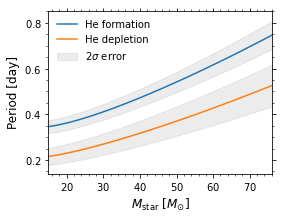

In [15]:
rsun = 696340 *1e5  #in cm
day_sec = 3600*24
msun = 1.989e33
x = np.arange(10,80,2.5)

plt.figure(figsize = (4,3))

y = (2e99*x)**(1/2)
R = 0.028*x + 1#.85
j = 1.25*(9e32*x)**(1/2)

mask = dataNT["abh"] > .9
rg = dataNT[mask]['AMfinal_He_form'] / (dataNT[mask]['MHe_form']*msun) / (dataNT[mask]['R_He_form']*rsun)**2 \
                / (dataNT[mask]['Omega_mean_He_form'])
rgmean = np.mean(rg)
rgstd = np.std(rg)


P = rgmean * 2*np.pi * (R*rsun)**2 / j
plt.plot(x, P / day_sec, label='He formation')

P_upper = (rgmean + 2*rgstd) * 2 * np.pi * (R * rsun)**2 / j
P_lower = (rgmean - 2*rgstd) * 2 * np.pi * (R * rsun)**2 / j
plt.fill_between(x, P_lower / day_sec, P_upper / day_sec, color='gray', alpha=0.15)

annotation_text = "smaller periods lead to \nstrong mass loss at collapse"
arrow_props = dict(color='black', arrowstyle='<-', linewidth = 1.5)

# --------------------------------- 2nd plot -----------------------------
# y = (2e99*x)**(1/2)
R = 0.028*x + .85
j = (8e32*x)**(1/2)
rg = dataNT[mask]['AMfinal_He_dep'] / (dataNT[mask]['MHe_dep']*msun) / (dataNT[mask]['R_He_dep']*rsun)**2 \
                / (dataNT[mask]['Omega_mean_He_dep'])
rgmean = np.mean(rg)
rgstd = np.std(rg)

P = rgmean * 2*np.pi * (R*rsun)**2 / j
plt.plot(x, P / day_sec, label='He depletion')

P_upper = (rgmean + 2*rgstd) * 2 * np.pi * (R * rsun)**2 / j
P_lower = (rgmean - 2*rgstd) * 2 * np.pi * (R * rsun)**2 / j
plt.fill_between(x, P_lower / day_sec, P_upper / day_sec, color='gray', alpha=0.15, label='2$\\sigma$ error')


plt.legend(loc = 'upper left', fontsize = 10)
plt.xlim(15,76)
plt.locator_params(axis='y', nbins=6)

plt.xlabel('$M_{\\rm star} \,\, [M_{\\odot}]$', fontsize = 12)
plt.ylabel('Period [day]', fontsize = 12)
plt.savefig('./MHe_vs_period.png')

## Additional (supplementry) figures not presented in the paper

$r_g^2$ =  0.041428571798603896
std =  0.0036096373546498943


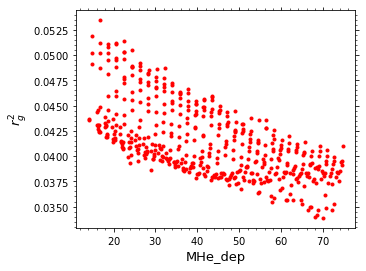

In [128]:
### Calculating radius of gyration (sample exercise)

mask = dataNT["abh"] > .9
msun = 1.989e33
rsun = rsun = 696340 *1e5  #in cm
# note that I do not know omega so have assuemd a period of 0.5 ----- SAVE THIS IN CODE or maybe save rg itself
rg = dataNT[mask]['AMfinal_He_dep'] / (dataNT[mask]['MHe_dep']*msun) / (dataNT[mask]['R_He_dep']*rsun)**2 \
                / (dataNT[mask]['Omega_mean_He_dep'])

# core_he  = data[mask]['MHe_dep'] /  data[mask]['MHe_form']
plt.scatter(dataNT[mask]['MHe_dep'], rg, color = 'r')

plt.xlabel('MHe_dep')
plt.ylabel('$r_g^2$')
rgmean = np.mean(rg)
rgstd = np.std(rg)
print('$r_g^2$ = ', np.mean(rg))
print('std = ',np.std(rg))

Text(0, 0.5, 'Rexp')

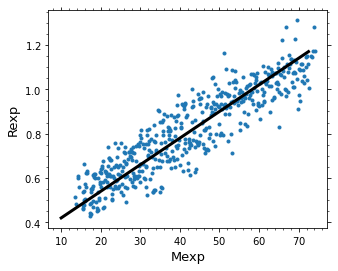

In [129]:
### mass radius relation
mask = dataNT["abh"] > 0.9
plt.scatter(dataNT[mask]['Mexp'], dataNT[mask]['Rexp'])#, z='Mbh')
# plt.ylim(1,5)

x = np.arange(10,75,2.5)
# y = (2e99*x)**(1/2)
# y = (0.85/60)*(x - 20) + 0.65
y = 0.012*x + .3
plt.plot(x, y, linewidth = 3, color = 'k')
# y = (0.132*x)**0.5
# plt.plot(x, y, linewidth = 3, color = 'r')
plt.xlabel('Mexp')
plt.ylabel('Rexp')